Hypothesis
======

I am to model the data according to response "PG5_1RRPQ" - Resolve Reported Problem Quickly.
The details about a respondants:

* position at time of commit
* level of developement experience 
* age 

Are prime candidates for predictors as the job position is indicitive of the work being done. Software Engineer may want maintainable code and elect a solution that is not immediate, but sustainable. Other position may want a quick solution that is discardable. Developer experience plays into effect as developers with lesser experience may opt for solutions that cut corners for immediate satisfaction. Gender was intended to be used but there were more male responses than female responses, so age was elected instead as a predictor as yoounger individuals would be expected to find a solution that requires less work on their end as they are typically "fire and forget" programmers. 

Modelling
======
I plan on using a linear regression model using the predictors above.

I will attribute to position at time of commit the following values:

* Software Engineer - 3
* Data Scientist - 2
* Other - 1

I will attribute to level of experience the following values:

* <2 Years - 6
* 2-5 Years - 5
* 6-8 Years - 4
* 9-12 Years - 3
* 13-19 Years - 2
* 20+ Years - 1

I will attribute to age the following values:

* 18-24 - 6
* 25-34 - 5
* 35-44 - 4
* 45-54 - 3
* 55-64 - 2
* 65+   - 1

In [34]:
# For nicer printing
options(digits=2);

#libraries
library(dplyr);
library(tidyr);
library(ggplot2);
library(reshape2);
library(RColorBrewer);

In [23]:
# Read in the data
data <- read.csv("TechSurvey - Survey.csv",header=T);

#remove other variables, not involved with the repsonse RRPQ
extra_vars <- c("PG5_2BNUI",
                "PG5_2Order",
                "PG5_3HDS",
                "PG5_3Order",
                "PG5_4VGP",
                "PG5_4Order",
                "PG5_5PHR",
                "PG5_5Order",
                "PG5_6SSYOP",
                "PG5_6Order",
                "PG5_7NDYP",
                "PG5_7Order",
                "PG5_8CP",
                "PG5_8Order",
                "PG5_9FRP",
                "PG5_9Order",
                "PG5_10RPA",
                "PG5_10Order",
                "PG5_11NSG",
                "PG5_11Order",
                "PG5_12NWG",
                "PG5_12Order",
                "PG5_13NFG",
                "PG5_13Order")

#divide off data fields of extra_vars from data set
data <- data %>% select(-c(extra_vars))

#convert date to unix second
for (i in c("Start", "End")) 
    data[,i] = as.numeric(as.POSIXct(strptime(data[,i], "%Y-%m-%d %H:%M:%S")))
for (i in 0:12){
    vnam = paste(c("PG",i,"Submit"), collapse="")
    data[,vnam] = as.numeric(as.POSIXct(strptime(data[,vnam], "%Y-%m-%d %H:%M:%S")))
}
#calculate differences in time    
for (i in 12:0){
    pv = paste(c("PG",i-1,"Submit"), collapse="");
    if (i==0) 
        pv="Start";
    vnam = paste(c("PG",i,"Submit"), collapse="");
    data[,vnam] = data[,vnam] -data[,pv];
}

#remove not completed
data_completed = filter(data, Completed == TRUE)

In [24]:
#now explore variables
summary(data);

     Device    Completed       Start               End               PG0Dis   
        :  2   0    :  2   Min.   :1.54e+09   Min.   :1.54e+09   Min.   :  0  
 Bot    :  1   FALSE:546   1st Qu.:1.54e+09   1st Qu.:1.54e+09   1st Qu.:  0  
 PC     :955   TRUE :805   Median :1.54e+09   Median :1.54e+09   Median :  1  
 Phone  :376               Mean   :1.54e+09   Mean   :1.54e+09   Mean   : 44  
 Tablet : 16               3rd Qu.:1.54e+09   3rd Qu.:1.54e+09   3rd Qu.: 24  
 Unknown:  3               Max.   :1.54e+09   Max.   :1.54e+09   Max.   :168  
                           NA's   :2          NA's   :548        NA's   :73   
    PG0Shown      PG0Submit    
 Min.   :   0   Min.   :    2  
 1st Qu.:   0   1st Qu.:    6  
 Median : 102   Median :    9  
 Mean   : 249   Mean   :  299  
 3rd Qu.: 428   3rd Qu.:   15  
 Max.   :1190   Max.   :76226  
 NA's   :73     NA's   :199    
                                       PG1PsnUse  
 For personal work and/or research use      :727  
          

### Interpret  basic summaries

In [25]:
#get numeric fields only for correlation
sel = c()
for (i in 1:dim(data)[2]) if (is.numeric(data[,i])) sel = c(sel, i);


cor(data[,sel],method="spearman",use="pairwise.complete.obs"); #OK for any: uses ranks

,Start,End,PG0Dis,PG0Shown,PG0Submit,PG1Submit,PG2Submit,PG3Submit,PG4Dtr0_6,PG4Psv7_8,...,PG4Submit,PG5_1Order,PG5Submit,PG6Submit,PG7Submit,PG8Submit,PG9Submit,PG10Submit,PG11Submit,PG12Submit
Start,1.0000,0.9952,-0.0417,-0.11507,0.135,0.1156,0.0791,0.0384,0.01210,0.00371,...,0.019,0.0218,0.08512,0.0054,0.0776,0.044,0.04101,0.047,7.9e-02,0.075
End,0.9952,1.0000,-0.0415,-0.09879,0.114,0.1550,0.0791,0.0511,-0.05185,-0.04576,...,0.017,0.0196,0.09088,0.0051,0.0759,0.044,0.04071,0.052,7.9e-02,0.077
PG0Dis,-0.0417,-0.0415,1.0000,0.87220,0.015,0.0065,0.0041,0.0567,0.16368,0.02668,...,-0.054,0.0140,0.00601,0.0277,0.0097,0.035,0.00995,-0.029,-4.5e-02,0.055
PG0Shown,-0.1151,-0.0988,0.8722,1.00000,0.036,0.0205,0.0023,0.0497,0.08226,0.00036,...,-0.060,0.0125,-0.00888,0.0401,0.0121,0.026,0.00056,-0.045,-7.1e-02,0.044
PG0Submit,0.1350,0.1142,0.0153,0.03596,1.000,0.1088,0.1037,0.1273,-0.00802,-0.03763,...,0.219,-0.0240,0.17671,0.1518,0.1365,0.126,0.17579,0.225,1.1e-01,0.110
PG1Submit,0.1156,0.1550,0.0065,0.02047,0.109,1.0000,0.1452,0.2688,-0.06852,0.05661,...,0.165,0.0750,0.24670,0.2414,0.1133,0.107,0.10895,0.170,7.4e-02,0.114
PG2Submit,0.0791,0.0791,0.0041,0.00235,0.104,0.1452,1.0000,0.2045,0.00146,0.00897,...,0.152,-0.0069,0.21851,0.2696,0.1245,0.157,0.20127,0.099,1.1e-01,0.107
PG3Submit,0.0384,0.0511,0.0567,0.04968,0.127,0.2688,0.2045,1.0000,0.00865,0.04424,...,0.196,0.0578,0.26048,0.2706,0.1316,0.182,0.27450,0.161,1.4e-01,0.164
PG4Dtr0_6,0.0121,-0.0518,0.1637,0.08226,-0.008,-0.0685,0.0015,0.0087,1.00000,NA,...,-0.143,-0.0949,-0.05214,-0.1618,0.1560,0.070,-0.07292,0.044,8.4e-04,-0.027
PG4Psv7_8,0.0037,-0.0458,0.0267,0.00036,-0.038,0.0566,0.0090,0.0442,NA,1.00000,...,-0.083,-0.0140,0.08974,-0.0146,-0.0363,0.053,0.05977,0.069,-4.9e-02,-0.022


Interpret correlations: onlys start vs End, calculate differene instead


In [86]:
# Get rid of empty responses
new_data <- filter(data, PG5_1RRPQ != "")
new_data <- filter(data, PG6Resp != "")
new_data <- filter(data, PG8Resp != "")
new_data <- filter(data, PG12Resp != "")

# Convert PG6Resp to be usable by linear regression model
levels(data$PG6Resp) <- c(levels(data$PG6Resp), 0, 1, 2, 3, 4, 5, 6)
new_data$PG6Resp <- replace(new_data$PG6Resp, which(new_data$PG6Resp == ""), '0')
new_data$PG6Resp <- replace(new_data$PG6Resp, which(new_data$PG6Resp == "Less than 2 years"), '6')
new_data$PG6Resp <- replace(new_data$PG6Resp, which(new_data$PG6Resp == "2 - 5 years"), '5')
new_data$PG6Resp <- replace(new_data$PG6Resp, which(new_data$PG6Resp == "6 - 8 years"), '4')
new_data$PG6Resp <- replace(new_data$PG6Resp, which(new_data$PG6Resp == "9 - 12 years"), '3')
new_data$PG6Resp <- replace(new_data$PG6Resp, which(new_data$PG6Resp == "13 - 19 years"), '2')
new_data$PG6Resp <- replace(new_data$PG6Resp, which(new_data$PG6Resp == "20 years or more"), '1')
new_data <- transform(new_data, PG6Resp = as.numeric(as.character(PG6Resp)))

# Convert PG9Resp to be usable by linear regression model
levels(data$PG8Resp) <- c(levels(data$PG8Resp), 0, 1, 2, 3, 4, 5, 6)
new_data$PG8Resp <- replace(new_data$PG8Resp, which(new_data$PG8Resp == ""), '0')
new_data$PG8Resp <- replace(new_data$PG8Resp, which(new_data$PG8Resp == "Other"), '1')
new_data$PG8Resp <- replace(new_data$PG8Resp, which(new_data$PG8Resp != "Software Engineer" &
                                                    new_data$PG8Resp != "Data Scientist"), '6')
new_data$PG8Resp <- replace(new_data$PG8Resp, which(new_data$PG8Resp == "Data Scientist"), '3')
new_data$PG8Resp <- replace(new_data$PG8Resp, which(new_data$PG8Resp == "Software Engineer"), '1')
new_data <- transform(new_data, PG8Resp = as.numeric(as.character(PG8Resp)))

# Convert PG12Resp to be usable by linear regression model
levels(data$PG12Resp) <- c(levels(data$PG12Resp), 0, 1, 2, 3, 4, 5, 6)
new_data$PG12Resp <- replace(new_data$PG12Resp, which(new_data$PG12Resp == ""), '0')
new_data$PG12Resp <- replace(new_data$PG12Resp, which(new_data$PG12Resp == "18 - 24"), '6')
new_data$PG12Resp <- replace(new_data$PG12Resp, which(new_data$PG12Resp == "25 - 34"), '5')
new_data$PG12Resp <- replace(new_data$PG12Resp, which(new_data$PG12Resp == "35 - 44"), '4')
new_data$PG12Resp <- replace(new_data$PG12Resp, which(new_data$PG12Resp == "45 - 54"), '3')
new_data$PG12Resp <- replace(new_data$PG12Resp, which(new_data$PG12Resp == "55 - 64"), '2')
new_data$PG12Resp <- replace(new_data$PG12Resp, which(new_data$PG12Resp == "65 and over"), '1')
new_data <- transform(new_data, PG12Resp = as.numeric(as.character(PG12Resp)))

#Convert PG5_1RRPQ to be usable by linear regression model
levels(data$PG5_1RRPQ) <- c(levels(data$PG5_1RRPQ), 0, 1, 2, 3, 4, 5)
new_data$PG5_1RRPQ <- replace(new_data$PG5_1RRPQ, which(new_data$PG5_1RRPQ == ""), '0')
new_data$PG5_1RRPQ <- replace(new_data$PG5_1RRPQ, which(new_data$PG5_1RRPQ == "Not a Priority"), '1')
new_data$PG5_1RRPQ <- replace(new_data$PG5_1RRPQ, which(new_data$PG5_1RRPQ == "Low Priority"), '2')
new_data$PG5_1RRPQ <- replace(new_data$PG5_1RRPQ, which(new_data$PG5_1RRPQ == "Medium Priority"), '3')
new_data$PG5_1RRPQ <- replace(new_data$PG5_1RRPQ, which(new_data$PG5_1RRPQ == "High Priority"), '4')
new_data$PG5_1RRPQ <- replace(new_data$PG5_1RRPQ, which(new_data$PG5_1RRPQ == "Essential"), '5')
new_data <- transform(new_data, PG5_1RRPQ = as.numeric(as.character(PG5_1RRPQ)))

print(summary(new_data$PG6Resp))
print(summary(new_data$PG8Resp))
print(summary(new_data$PG12Resp))
print(summary(new_data$PG5_1RRPQ))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     4.0     5.0     4.5     5.0     6.0 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0     3.0     3.0     4.3     6.0     6.0 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0     4.0     4.0     4.3     5.0     6.0 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     1.0     1.7     3.0     5.0 


In [87]:
# Define a function
hiCor <- function(data, level){
  results <- cor(data, method="spearman", use="pairwise.complete.obs");
  # set NA to 0
  results[is.na(results)] <- 0
  
  # convert negative correlations to positive
  pos_results <- results;
  pos_results[results < 0] <- -results[results < 0];
    
  # set diagonal to 0
  for (i in 1:dim(data)[2]){
    pos_results[i,i] <- 0;
  }
  
  sel <- apply(pos_results, 1, max) > level;
  results[sel,sel];
}
high_corr <- hiCor(new_data[, sel],.7)

# print high correlations
print(summary(high_corr))

     Start            End            PG0Dis         PG0Shown    
 Min.   :-0.09   Min.   :-0.11   Min.   :-0.05   Min.   :-0.09  
 1st Qu.:-0.05   1st Qu.:-0.06   1st Qu.:-0.02   1st Qu.:-0.04  
 Median :-0.03   Median :-0.03   Median : 0.02   Median : 0.01  
 Mean   : 0.21   Mean   : 0.21   Mean   : 0.26   Mean   : 0.24  
 3rd Qu.: 0.24   3rd Qu.: 0.24   3rd Qu.: 0.42   3rd Qu.: 0.40  
 Max.   : 1.00   Max.   : 1.00   Max.   : 1.00   Max.   : 1.00  
   PG4Dtr0_6       PG4Psv7_8       PG4Prm9_10      PG4AllResp   
 Min.   :-0.11   Min.   :-0.05   Min.   :-0.01   Min.   :-0.02  
 1st Qu.:-0.02   1st Qu.:-0.03   1st Qu.:-0.01   1st Qu.:-0.01  
 Median : 0.12   Median : 0.00   Median : 0.00   Median : 0.50  
 Mean   : 0.29   Mean   : 0.24   Mean   : 0.25   Mean   : 0.49  
 3rd Qu.: 0.46   3rd Qu.: 0.27   3rd Qu.: 0.28   3rd Qu.: 1.00  
 Max.   : 1.00   Max.   : 1.00   Max.   : 1.00   Max.   : 1.00  



Call:
lm(formula = PG5_1RRPQ ~ PG6Resp, data = new_data)

Residuals:
   Min     1Q Median     3Q    Max 
-1.758 -1.697 -0.635  1.303  3.550 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.3885     0.2060    6.74  3.1e-11 ***
PG6Resp       0.0616     0.0436    1.41     0.16    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.7 on 761 degrees of freedom
Multiple R-squared:  0.00262,	Adjusted R-squared:  0.00131 
F-statistic:    2 on 1 and 761 DF,  p-value: 0.158


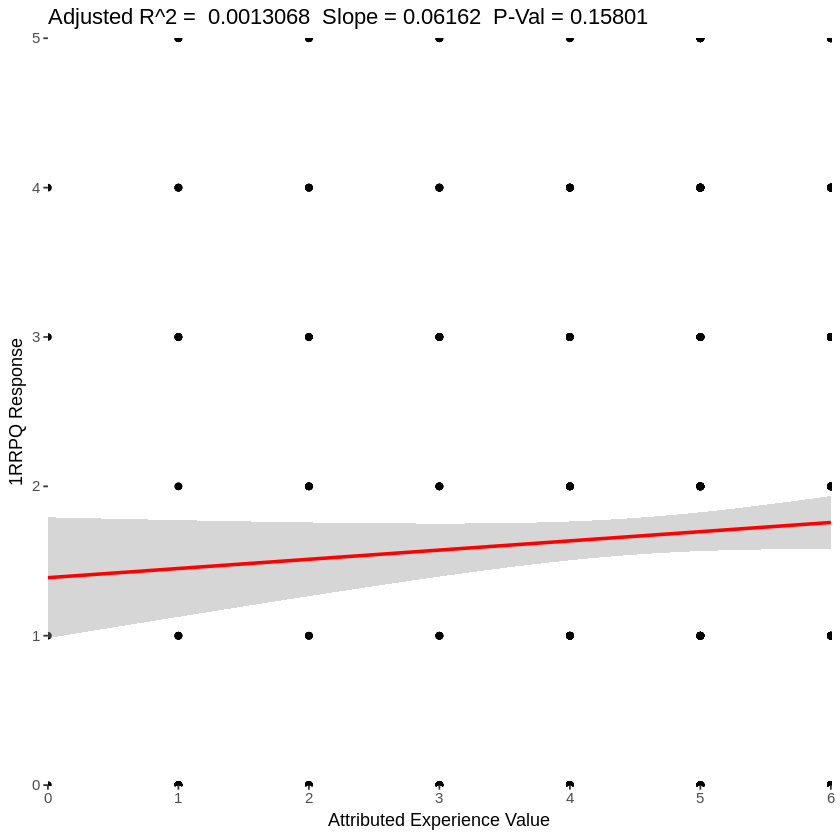

In [88]:
model_pg6 <- lm(PG5_1RRPQ ~ PG6Resp, data = new_data)
summary(model_pg6)

exp_plot <- ggplot(new_data, aes(x = PG6Resp, y = PG5_1RRPQ)) + 
  geom_point() +
  stat_smooth(method = "lm", col = "red") +
  labs(title = paste("Adjusted R^2 = ",signif(summary(model_pg6)$adj.r.squared, 5),
                     " Slope =",signif(model_pg6$coef[[2]], 5),
                     " P-Val =",signif(summary(model_pg6)$coef[2,4], 5)))
print(exp_plot + 
    scale_y_continuous(name = "1RRPQ Response", breaks = seq(0, 5, by=1), expand = c(0, 0)) + 
    scale_x_continuous(name = "Attributed Experience Value", breaks = seq(0, 6, by=1), expand = c(0, 0)) + 
    theme(panel.background = element_blank(),
          plot.background = element_blank()))


Call:
lm(formula = PG5_1RRPQ ~ PG8Resp, data = new_data)

Residuals:
   Min     1Q Median     3Q    Max 
-1.726 -1.622 -0.622  1.378  3.448 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.5176     0.1704    8.91   <2e-16 ***
PG8Resp       0.0347     0.0371    0.93     0.35    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.7 on 761 degrees of freedom
Multiple R-squared:  0.00115,	Adjusted R-squared:  -0.000166 
F-statistic: 0.874 on 1 and 761 DF,  p-value: 0.35


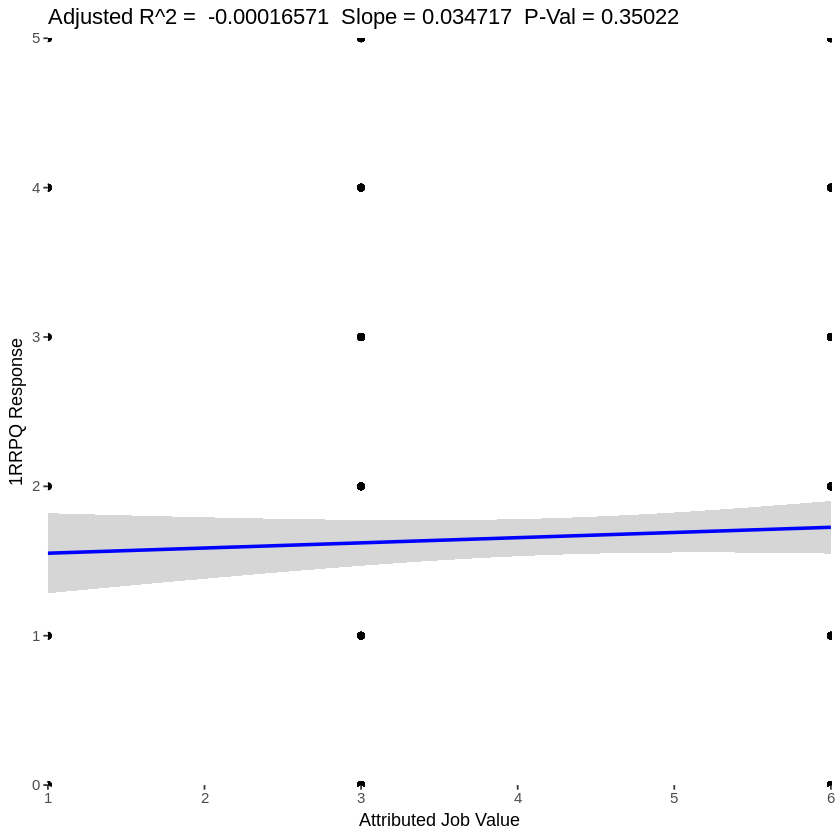

In [89]:
model_pg8 <- lm(PG5_1RRPQ ~ PG8Resp, data = new_data)
summary(model_pg8)

pos_plot <- ggplot(new_data, aes(x = PG8Resp, y = PG5_1RRPQ)) + 
  geom_point() +
  stat_smooth(method = "lm", col = "blue") +
  labs(title = paste("Adjusted R^2 = ",signif(summary(model_pg8)$adj.r.squared, 5),
                     " Slope =",signif(model_pg8$coef[[2]], 5),
                     " P-Val =",signif(summary(model_pg8)$coef[2,4], 5)))

print(pos_plot + 
    scale_y_continuous(name = "1RRPQ Response", breaks = seq(0, 5, by=1), expand = c(0, 0)) + 
    scale_x_continuous(name = "Attributed Job Value", breaks = seq(0, 6, by=1), expand = c(0, 0)) + 
    theme(panel.background = element_blank(),
          plot.background = element_blank()))


Call:
lm(formula = PG5_1RRPQ ~ PG12Resp, data = new_data)

Residuals:
   Min     1Q Median     3Q    Max 
-1.775 -1.647 -0.647  1.353  3.481 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.3907     0.2842    4.89  1.2e-06 ***
PG12Resp      0.0641     0.0646    0.99     0.32    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.7 on 761 degrees of freedom
Multiple R-squared:  0.00129,	Adjusted R-squared:  -1.98e-05 
F-statistic: 0.985 on 1 and 761 DF,  p-value: 0.321


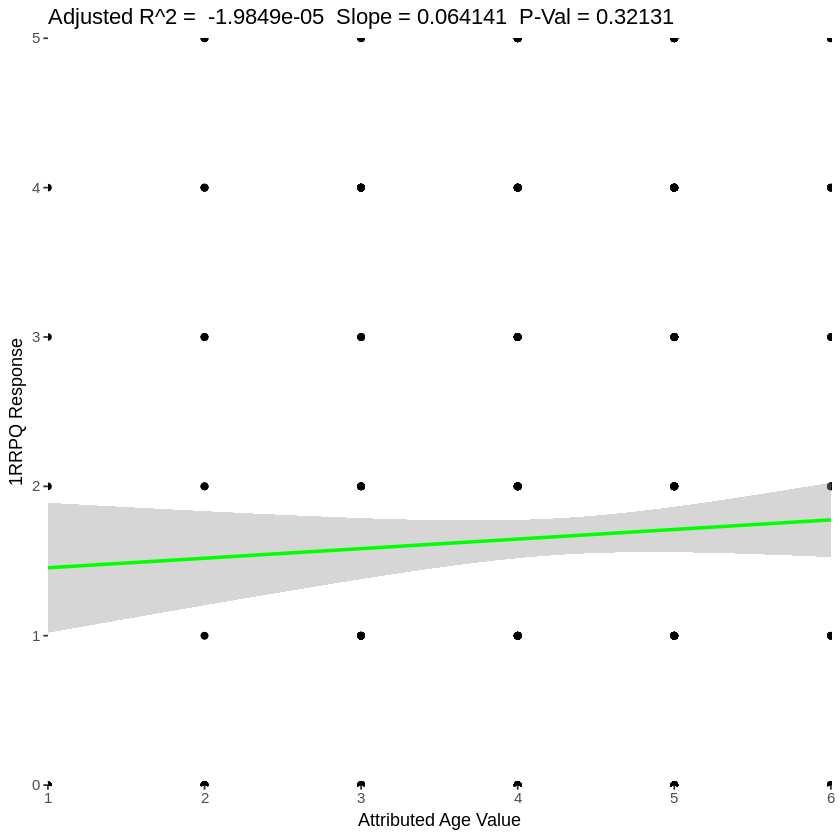

In [81]:
model_pg12 <- lm(PG5_1RRPQ ~ PG12Resp, data = new_data)
summary(model_pg12)

age_plot <- ggplot(new_data, aes(x = PG12Resp, y = PG5_1RRPQ)) + 
  geom_point() +
  stat_smooth(method = "lm", col = "green") +
  labs(title = paste("Adjusted R^2 = ",signif(summary(model_pg12)$adj.r.squared, 5),
                     " Slope =",signif(model_pg12$coef[[2]], 5),
                     " P-Val =",signif(summary(model_pg12)$coef[2,4], 5)))

print(age_plot + 
    scale_y_continuous(name = "1RRPQ Response", breaks = seq(0, 5, by=1), expand = c(0, 0)) + 
    scale_x_continuous(name = "Attributed Age Value", breaks = seq(0, 6, by=1), expand = c(0, 0)) + 
    theme(panel.background = element_blank(),
          plot.background = element_blank()))


Call:
lm(formula = PG5_1RRPQ ~ PG6Resp + PG8Resp + PG12Resp, data = new_data)

Residuals:
   Min     1Q Median     3Q    Max 
-1.834 -1.654 -0.639  1.346  3.671 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   1.1492     0.3625    3.17   0.0016 **
PG6Resp       0.0487     0.0473    1.03   0.3043   
PG8Resp       0.0660     0.1050    0.63   0.5300   
PG12Resp      0.0324     0.0696    0.47   0.6413   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.7 on 759 degrees of freedom
Multiple R-squared:  0.00348,	Adjusted R-squared:  -0.000457 
F-statistic: 0.884 on 3 and 759 DF,  p-value: 0.449


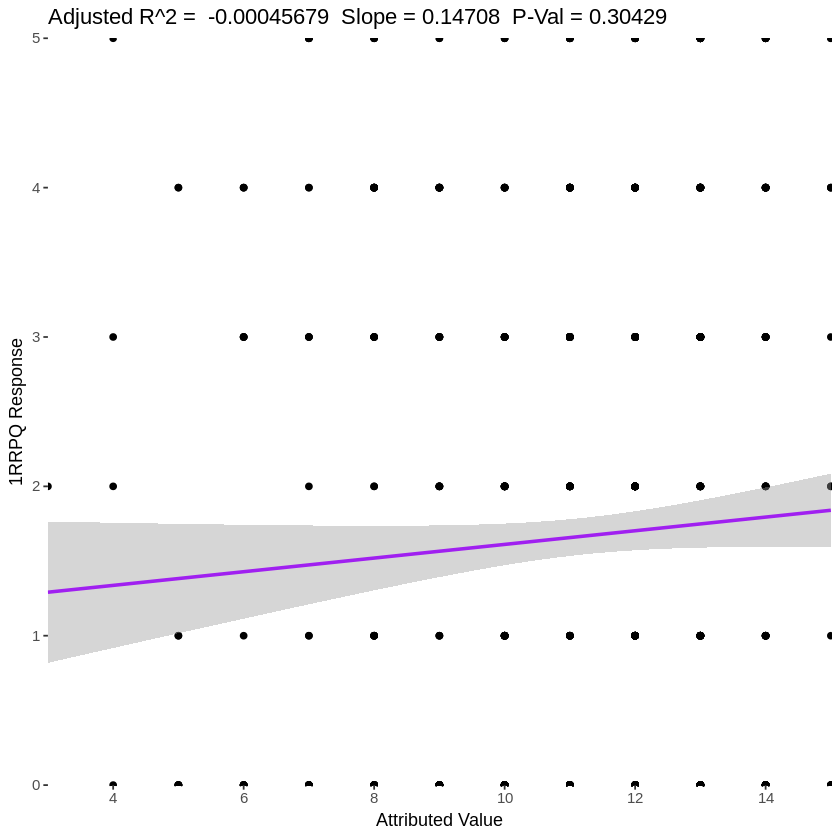

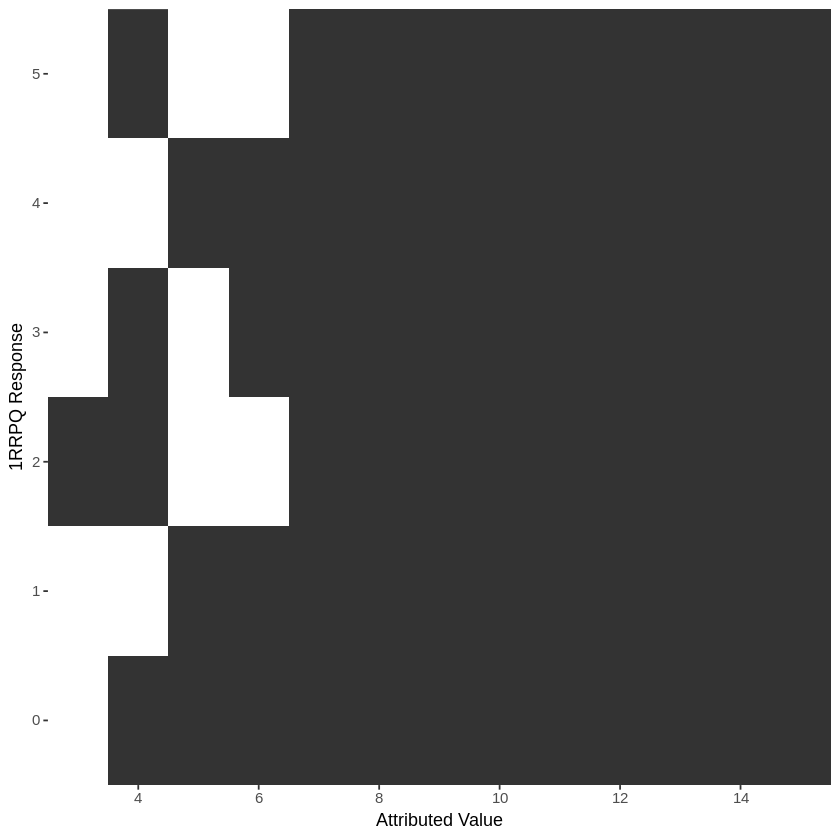

In [70]:
model_all <- lm(PG5_1RRPQ ~ PG6Resp + PG8Resp + PG12Resp, data = new_data)
summary(model_all)

entire <- ggplot(new_data, aes(x = PG6Resp + PG8Resp + PG12Resp, y = PG5_1RRPQ)) + 
  geom_point() +
  stat_smooth(method = "lm", col = "purple") +
  labs(title = paste("Adjusted R^2 = ",signif(summary(model_all)$adj.r.squared, 5),
                     " Slope =",signif(model_all$coef[[2]] + model_all$coef[[3]] + model_all$coef[[4]], 5),
                     " P-Val =",signif(summary(model_all)$coef[2,4], 5)))
print(entire + 
    scale_y_continuous(name = "1RRPQ Response", breaks = seq(0, 5, by=1), expand = c(0, 0)) + 
    scale_x_continuous(name = "Attributed Value", breaks = seq(0, 16, by=2), expand = c(0, 0)) + 
    theme(panel.background = element_blank(),
          plot.background = element_blank()))


hm.palette <- colorRampPalette(rev(brewer.pal(9, 'Blues')), space='Lab')
heatmap_print <- ggplot(new_data, aes(x = PG6Resp + PG8Resp + PG12Resp, y = PG5_1RRPQ)) + 
geom_tile(aes(height=1)) +
scale_fill_gradientn(colours = hm.palette(1000)) 
print(heatmap_print + 
    scale_y_continuous(name = "1RRPQ Response", breaks = seq(0, 5, by=1), expand = c(0, 0)) + 
    scale_x_continuous(name = "Attributed Value", breaks = seq(0, 16, by=2), expand = c(0, 0)) + 
    theme(panel.background = element_blank(),
          plot.background = element_blank()))

It would appear that my hypothesis is neither disproven or proven by the data I have modelled. It appears that my thoughts stand correct in a general sense but do not take hold entirely. For one, the P-Value for multiple correlations is quite high as well as the R^2 values. The R^2 Values are understandable as the responses come from human input which typically skews the data. The P-Values are higher than I would have hoped them to be. All the correlations may be positive but the amount in which they are is nelgigible. Furthermore, the P-Value being as high as it is leads me to believe that I have been incorrect in the way that I have fashioned the model for my data. I would have hoped for values to show more of a correlation but the high value of P may be due to my assumptions and attributed values.


I would definiely take another crack at this again once I understand a bit more about the methodologies and how R operates.

### Recommendations
I think it would be best if the data was not required to listed in particular order, that some of the questions could be listed in the same priorities. This would make the questions more natural and a person would not have to force themselves to list something that they think is of equal priority to another in a lower priotity.

I also think that it would be beneficial to require a response from every question before submission.